IMPORTS

In [1]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

DATASET PREPROCESSING

In [2]:
venomous_classes = ["barredcoral snake", "king cobra", "north ph temple pitviper"]

def csv_to_binary_labels(csv_path, image_dir):
    df = pd.read_csv(csv_path)

    class_cols = df.columns[1:]
    df["label"] = df[class_cols].idxmax(axis=1)

    df["binary_label"] = df["label"].apply(lambda x: 1 if x in venomous_classes else 0)

    df_binary = df[["filename", "binary_label"]].copy()
    df_binary["filename"] = df_binary["filename"].apply(lambda x: f"{image_dir}/{x}")

    df_binary["binary_label"] = df_binary["binary_label"].astype(str)

    return df_binary

TRAIN AND VALIDATION DATAFRAME GENERATOR

In [3]:
train_df = csv_to_binary_labels("../dataset/train/_classes.csv", "../dataset/train")
val_df   = csv_to_binary_labels("../dataset/valid/_classes.csv", "../dataset/valid")
test_df  = csv_to_binary_labels("../dataset/test/_classes.csv", "../dataset/test")

datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess_input)
train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="filename", y_col="binary_label",
    target_size=(224, 224), batch_size=16,
    class_mode="binary", shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    val_df, x_col="filename", y_col="binary_label",
    target_size=(224, 224), batch_size=16,
    class_mode="binary", shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    test_df, x_col="filename", y_col="binary_label",
    target_size=(224, 224), batch_size=16,
    class_mode="binary", shuffle=False
)

Found 6300 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.


MODEL TRAINING

In [4]:
model_path = "densenet201_finetuned_model.h5"

if os.path.exists(model_path):
    print(f"✅ Loading pre-trained model from {model_path}")
    model = load_model(model_path)
else:
    print("🚀 Training new model...")
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:-5]:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['binary_label'].astype(int)),
        y=train_df['binary_label'].astype(int)
    )
    class_weights = dict(enumerate(class_weights))

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[TqdmCallback(verbose=1)]
    )

    model.save(model_path)
    print(f"💾 Model saved as {model_path}")

✅ Loading pre-trained model from densenet201_finetuned_model.h5


DATA VALIDATION METRICS

In [5]:
# Evaluate the Model on Validation Data
validation_scores = model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(validation_scores[1] * 100))
print("Validation Precision: {:.2f}%".format(validation_scores[2] * 100))
print("Validation Recall: {:.2f}%".format(validation_scores[3] * 100))

c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9300 - loss: 0.1845 - precision: 0.9169 - recall: 0.9511
Validation Accuracy: 93.67%
Validation Precision: 93.19%
Validation Recall: 94.95%


DATA TEST METRICS

In [6]:
# Evaluate the Model on Test Data
test_scores = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_scores[1] * 100))
print("Test Precision: {:.2f}%".format(test_scores[2] * 100))
print("Test Recall: {:.2f}%".format(test_scores[3] * 100))

57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9187 - loss: 0.2294 - precision: 0.9291 - recall: 0.9416
Test Accuracy: 80.11%
Test Precision: 77.69%
Test Recall: 86.51%


GENERATING PREDICTIONS 

In [7]:
# Generate predictions
test_generator.reset()
y_pred = model.predict(test_generator).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_df["binary_label"].values
y_true = [int(label) for label in y_true]

57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


DENSENET TEST DATA CONFUSION MATRIX

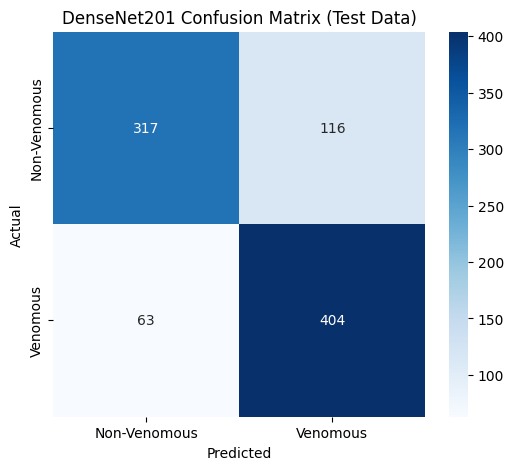

In [8]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Venomous", "Venomous"],
            yticklabels=["Non-Venomous", "Venomous"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('DenseNet201 Confusion Matrix (Test Data)')
plt.show()